Notebook author: Makar Shevchenko B20-DS-01

# Data Exploration and Preprocessing

Execute this notebook in Google Colab

In this notebook I explore and preprocess the ParaNMT-detox corpus. This dataset is a subset of the ParaNMT corpus, which contain 500k pairs of toxic and neutral sentences. Each sentence is labeled with toxicity level, that is toxic assesments over annotators number. With preprocessing I adopt the raw data for training and evaluation of the text detoxification algorithms implemented in `2.0-model-training-and-visualization.ipynb`.

## Configuration

Define the parameters for notebook behavior

In [15]:
TSV_PATH = "./filtered.tsv"
URL = "https://github.com/skoltech-nlp/detox/releases/download/emnlp2021/filtered_paranmt.zip"
ZIP_SAVE_PATH = "./filtered.zip"
TSV_SAVE_DIR = "."

## Imports

Import libraries utilized next

In [16]:
!pip install wget

import os
import wget
import nltk
import pandas as pd
from pprint import pprint
from zipfile import ZipFile
from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Exploration

Data exploration step collects data, familiarize with it, and identifies quality problems. The data exploration step is key to finding out the technical feasibility of the task.

### Data Collection

Load the dataset from the Internet, store along with the notebook, and open with `.tsv` reader

In [17]:
if not os.path.isfile(TSV_PATH):
    wget.download(URL, ZIP_SAVE_PATH)
    with ZipFile(ZIP_SAVE_PATH, "r") as zip_file:
        zip_file.extractall(TSV_SAVE_DIR)
    os.remove(ZIP_SAVE_PATH)
dataset = pd.read_csv(TSV_PATH, sep="\t", index_col=0)

### Data Description

Explore data structure, check some samples

In [18]:
print(f"Shape: {dataset.shape}\n")
print(f"Column datatypes:")
dataset.info()
print()
dataset.sample(5, random_state=42)

Shape: (577777, 6)

Column datatypes:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 577777 entries, 0 to 577776
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   reference    577777 non-null  object 
 1   translation  577777 non-null  object 
 2   similarity   577777 non-null  float64
 3   lenght_diff  577777 non-null  float64
 4   ref_tox      577777 non-null  float64
 5   trn_tox      577777 non-null  float64
dtypes: float64(4), object(2)
memory usage: 30.9+ MB



,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
57809,"Listen, call off the butchers, and I'll tell you.",call out your butchers and I'll tell you.,0.761781,0.160000,0.005592,0.968063
132693,Who the fuck has been going through my stuff?!,who the hell was going through my stuff?,0.898699,0.127660,0.997644,0.452115
254505,She still might die . . .?,he can still die.,0.635970,0.333333,0.279049,0.989168
451186,"Yeah, that's the fucker's name.",that's what his name was.,0.652426,0.187500,0.999579,0.000055
191213,"I would take you on my shoulders, like, I'd st...",I'd take you on your shoulders... I'd tie you ...,0.790915,0.357143,0.961127,0.028628


Insights:
1. Reference might be not toxic, while translation is wise versa, i.e having toxicity value below 0.5 and above, respectively. In data preprocessing I might clear such samples.
2. Translation might be more toxic than reference (see the first and the third samples). It means in preprocessing I should remove such pairs. I also might reorder the sentences in pairs according to the toxicity level, but this will make the data "unnatural", which may cause problems with training and evaluation.

### Data Exploration

The data exploration step covers statistical, distributional analysis of the data, and a close look at the rows of the given dataset to detect relationships between the features

Analyse columns one by one

Start with reference and translation lens

[Text(0.5, 0, 'toxicity level')]

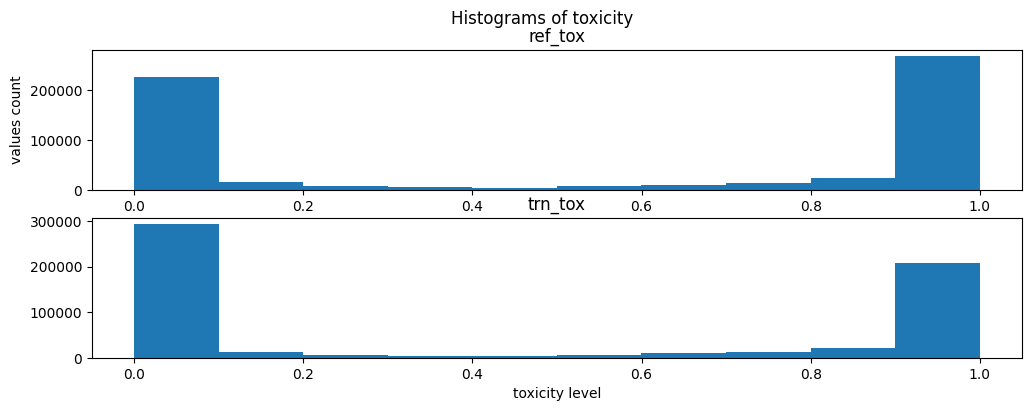

In [19]:
fig, axs = plt.subplots(2, figsize=(12, 4))
fig.suptitle('Histograms of toxicity')
axs[0].hist(dataset.loc[:, "ref_tox"])
axs[1].hist(dataset.loc[:, "trn_tox"])
axs[0].set_title('ref_tox')
axs[1].set_title('trn_tox')
axs[0].set(xlabel='toxicity level', ylabel='values count')
axs[1].set(xlabel='toxicity level')

Insight: most of the sentences are either 0% or 100% toxic

Share of samples where translation is more toxic than reference

In [20]:
f"Toxic translations: {Counter(dataset['trn_tox'] > dataset['ref_tox'])[True] / len(dataset):.2f}%"

'Toxic translations: 0.45%'

Analyse distribution of sequence lengths

[Text(0.5, 0, 'sequence len')]

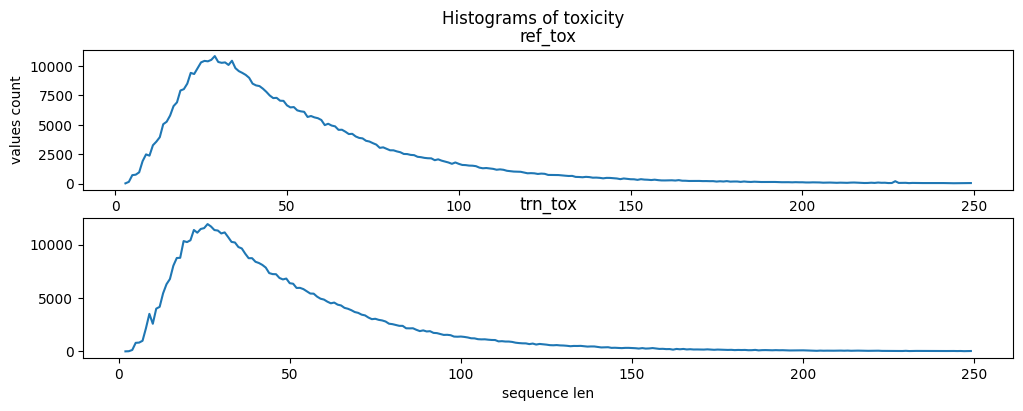

In [21]:
# let us see distribution of length to define a value of SEQ_LEN
ref_cnt = Counter((len(seq) for seq in dataset["reference"] if len(seq) < 250))
ref_cnt = sorted(dict(ref_cnt).items())
trn_cnt = Counter((len(seq) for seq in dataset["translation"] if len(seq) < 250))
trn_cnt = sorted(dict(trn_cnt).items())
fig, axs = plt.subplots(2, figsize=(12, 4))
fig.suptitle('Histograms of toxicity')
axs[0].plot([key for key, val in ref_cnt], [val for key, val in ref_cnt])
axs[1].plot([key for key, val in trn_cnt], [val for key, val in trn_cnt])
axs[0].set_title('ref_tox')
axs[1].set_title('trn_tox')
axs[0].set(xlabel='sequence len', ylabel='values count')
axs[1].set(xlabel='sequence len')

Insight: translation and reference lengths have the same distribution with a peak at 25 words and 90% of the sequences of the lengths is under 100

The most and the least toxic words

In [22]:
words_cnt = Counter((word
                     for seq in dataset["reference"]
                     for word in set(word_tokenize(seq))))
words_cnt += Counter((word
                      for seq in dataset["translation"]
                      for word in set(word_tokenize(seq))))
tox_words_cnt = Counter((word
                         for seq in dataset["reference"][dataset["ref_tox"] > 0.5]
                         for word in set(word_tokenize(seq))))
tox_words_cnt += Counter((word
                          for seq in dataset["translation"][dataset["trn_tox"] > 0.5]
                          for word in set(word_tokenize(seq))))
words_toxicity = {word: cnt / words_cnt[word] for word, cnt in tox_words_cnt.items() if cnt > 100}
print("The most toxic words:")
pprint(sorted(words_toxicity.items(), key=lambda k_v: k_v[1], reverse=True)[:15])
print("\nThe least toxic words:")
pprint(sorted(words_toxicity.items(), key=lambda k_v: k_v[1], reverse=True)[-15:])

The most toxic words:
[('Fuck', 1.0),
 ('motherfucker', 1.0),
 ('Bullshit', 1.0),
 ('Crap', 1.0),
 ('Fucking', 1.0),
 ('Dammit', 1.0),
 ('dumb-ass', 1.0),
 ('scumbag', 1.0),
 ('Stupid', 1.0),
 ('motherfuckers', 1.0),
 ('fuckers', 1.0),
 ('faggot', 1.0),
 ('morons', 1.0),
 ('motherfucking', 1.0),
 ('Fuckin', 1.0)]

The least toxic words:
[('Be', 0.26766304347826086),
 ('dull', 0.263681592039801),
 ('stuff', 0.2605820105820106),
 ('sleeping', 0.24289195775792038),
 ('laid', 0.23817567567567569),
 ('silent', 0.23790322580645162),
 ('madness', 0.2328519855595668),
 ('mess', 0.22549019607843138),
 ('mad', 0.21529068224050968),
 ('unhappy', 0.21492007104795738),
 ('bird', 0.20921450151057402),
 ('slept', 0.15558343789209536),
 ('messed', 0.13195342820181113),
 ('punk', 0.10849056603773585),
 ('quiet', 0.10321324245374879)]


### Data Quality Check

Null values

In [23]:
dataset.isnull().sum()

reference      0
translation    0
similarity     0
lenght_diff    0
ref_tox        0
trn_tox        0
dtype: int64

Insight: data is clear from null values

Now let us check duplicates.

In [24]:
dataset[dataset[["reference", "translation"]].duplicated(keep=False)]

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
13,"Come on, Cal, leave that shit alone.","come on, Cal, put it down.",0.660481,0.270270,0.999637,0.000279
27,Trying to keep me fucking drugged so I don't k...,you want to fool me so I don't know what's goi...,0.734157,0.208955,0.986213,0.010006
49,Funny how Nazis are always the bad guys.,why are the Nazis always the bad guys?,0.687431,0.048780,0.534716,0.014441
60,Your girlfriends are dead.,your friends are dead.,0.915111,0.148148,0.993116,0.012461
63,What the hell is going on?,what's going on here?,0.836245,0.185185,0.927012,0.000042
...,...,...,...,...,...,...
577625,We've been on top of these peckerwoods since t...,we've been tracking these maths since they sho...,0.715349,0.032258,0.000822,0.995479
577632,"Now, sign the fucking contract!",you better sign this contract.,0.666639,0.031250,0.999580,0.000075
577634,You're goddamn lucky to have any man feel that...,you're damn lucky to have a man who takes care...,0.760127,0.153846,0.969237,0.021008
577680,The fuck are you talking about?,what are you talking about?,0.786859,0.125000,0.999583,0.000041


Insight: duplicates should be removed

## Data Preprocessing

In this step I get rid of duplicates and remove entries where the translation is more toxic than reference

### Data Cleaning

Remove duplicates

In [25]:
print(dataset.shape)
dataset.drop_duplicates(["reference", "translation"], inplace=True)
print(dataset.shape)

(577777, 6)
(558133, 6)


### Inconsistent Data Fixing

Remove pairs where translation is more toxic than reference or reference is not toxic or translation is toxic (recall the insights from data description section)

In [26]:
print(dataset.shape)
dataset.drop(dataset[dataset["trn_tox"] > dataset["ref_tox"]].index, inplace=True)
print(dataset.shape)
dataset.drop(dataset[dataset["ref_tox"] < 0.5].index, inplace=True)
print(dataset.shape)
dataset.drop(dataset[dataset["trn_tox"] > 0.5].index, inplace=True)
print(dataset.shape)

(558133, 6)
(307725, 6)
(307725, 6)
(307725, 6)


Experimental approach: flip more toxic translations (recall the insight from data description section)

In [27]:
# dataset = dataset.apply(lambda row: (row[1], row[0], row[2], row[3], row[5], row[4]) if row[4] < row[5] else row, axis=1)
# dataset.loc[57809]